# Definining and learning a causal model - continuous variables

### necessary imports

In [1]:
import os 
from pprint import pprint

import matplotlib.pyplot as plt
import daft
import pandas as pd
import numpy as np
import pgmpy.models
from scipy.stats import norm , expon
import matplotlib.pyplot as plt
from pgmpy.factors.continuous import ContinuousFactor
import numpy as np
from scipy.special import beta


%matplotlib inline

### read the IBM Employee Attition Dataset here

In [2]:
data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
data.head()



,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
data.MonthlyRate.describe()

count     1470.000000
mean     14313.103401
std       7117.786044
min       2094.000000
25%       8047.000000
50%      14235.500000
75%      20461.500000
max      26999.000000
Name: MonthlyRate, dtype: float64

### get rid of unneccessary columns:


In [4]:
data["OverTime"]

0       Yes
1        No
2       Yes
3       Yes
4        No
       ... 
1465     No
1466     No
1467    Yes
1468     No
1469     No
Name: OverTime, Length: 1470, dtype: object

## plot the causal relation "Attrition" -> "YearsAtCompany"

<Axes:>

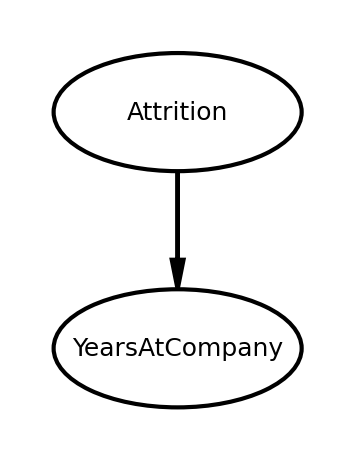

In [5]:
# ff = "comic sans ms"
# ff = "impact"
#ff = "times new roman"
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["font.size"] = 6

pgm = daft.PGM(aspect=2.1, dpi=300)
pgm.add_node("Attrition", r"Attrition", 2, 0)# 3.0, 2.0, observed=True)
pgm.add_node("YearsAtCompany", r"YearsAtCompany",2 ,-1)#5.0, 2.0, observed=True)
pgm.add_edge("Attrition", "YearsAtCompany")
#pgm.add_edge("ugly", "bad")
#pgm.add_edge("confused", "bad")

pgm.render()

### fit a normal distribution over 'YearsAtCompany', one for "Attrition=Yes" and one for "Attrition=No"

In [6]:
# Fit a normal distribution to the data:
#    remark: some asymmetric distribution might be more adept here to 
#        respect the circumstance that 'YearsAtCompany' > 0. For simplicity we ignore this here
mu_yes, std_yes = norm.fit(data[data["Attrition"]=="Yes"]["YearsAtCompany"])
mu_no, std_no = norm.fit(data[data["Attrition"]=="No"]["YearsAtCompany"])

# define a helper function modellng the depence of the variable on the covariate, attrition, 
def year_at_company_pdf(attrition: str, years_at_company):
    if attrition == "Yes":
        return norm.pdf(years_at_company, loc=mu_yes, scale=std_yes)    
    if attrition == "No":
        return norm.pdf(years_at_company, loc=mu_no, scale=std_no)

year_at_company_factor = ContinuousFactor(['Attrition', 'YearsAtCompany'], year_at_company_pdf)

In [7]:
year_at_company_factor.reduce([('Attrition', "Yes")])

In [8]:
year_at_company_factor.assignment(10)

0.04800336818631011

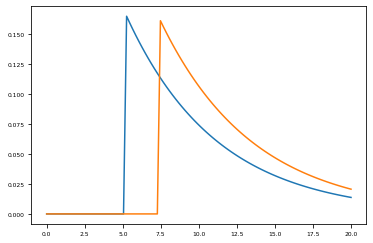

In [9]:
import numpy as np
from scipy.stats import norm, expon
import matplotlib.pyplot as plt
x = np.linspace(0, 20, 100)
y_yes = [expon.pdf(val, loc=mu_yes, scale=std_yes) for val in x]
y_no = [expon.pdf(val, loc=mu_no, scale=std_no) for val in x]
plt.plot(x, y_yes)
plt.plot(x, y_no)


### simulate a +10% in attrition=No (and so, less 10% in attrition=Yes)

In [10]:
attrition_no_base = data["Attrition"].value_counts(normalize=True)["No"]
attrition_yes_base = data["Attrition"].value_counts(normalize=True)["Yes"]
attrition_no_base*mu_no + attrition_yes_base*mu_yes
intervened_mean = (attrition_no_base+0.1)*mu_no + (attrition_yes_base-0.1)*mu_yes
intervened_mean

7.23198496189877

#### base 

In [11]:
base_mean = attrition_no_base*mu_no + attrition_yes_base*mu_yes
base_mean

7.0081632653061225

#### impact

In [12]:
intervened_mean - base_mean

0.2238216965926476

#### the difference is therefore around 0.224